<p style="text-align:center">
    <a href="https://nbviewer.jupyter.org/github/twMr7/Python-Machine-Learning/blob/master/18-ANN_Case_Studies.ipynb">
        Open In Jupyter nbviewer
        <img style="float: center;" src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" width="120" />
    </a>
</p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/Python-Machine-Learning/blob/master/18-ANN_Case_Studies.ipynb)

# 18. Artificial Neural Network - Case Studies

+ [**18.1 二元分類案例 – Breast Cancer Wisconsin 資料集**](#case-binary-classification)
    - 相關係數
    - 建構二元分類 DNN 模型
        - Weight Initializer and Activation
        - Batch Normalization
        - Regularizers
    - 準備佈署模型
+ [**18.2 多類別分類案例 – Iris 資料集**](#case-multilabel-classification)
    - 配對散佈圖
    - 建構多類別 DNN 分類模型
+ [**18.3 回歸案例**](#case-regression)
    - TODO
+ [**參考資料**](#references)


### Google Colab 環境

在 Google Colab 的環境下，請執行以下程式碼。（詳細說明請參閱 14 章）
```
from google.colab import drive
drive.mount('/content/drive')
```
建立 `dataset` 目錄的連結，記得修改成適合的路徑。
```
!ln -svf 'drive/My Drive/Lecture/Python Machine Learning/dataset' dataset
```

In [1]:
# 基本環境設定
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# 工具函式： 畫出 k-fold 訓練歷程記錄的 metrics 曲線
def plot_kfold_metrics(histories):
    metrics_keys = histories[0].model.metrics_names
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))   
    ax[0].set_title('Training Metrics', fontsize=14)
    ax[0].set_ylabel(metrics_keys[0], fontsize=14)
    ax[1].set_ylabel(metrics_keys[1], fontsize=14)
    ax[1].set_xlabel("Epoch", fontsize=14)
    for k,h in enumerate(histories):
        ax[0].plot(h.history[metrics_keys[0]], label='fold '+str(k))
        ax[1].plot(h.history[metrics_keys[1]], label='fold '+str(k))
    ax[0].legend()
    ax[1].legend()

In [3]:
# 工具函式： 畫出 Kearas 訓練歷程記錄的 metrics 曲線
def plot_metrics(history):
    metrics_keys = history.model.metrics_names
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))
    ax[0].set_title('Training Metrics', fontsize=14)
    ax[0].set_ylabel(metrics_keys[0], fontsize=14)
    ax[1].set_ylabel(metrics_keys[1], fontsize=14)
    ax[1].set_xlabel("Epoch", fontsize=14)
    ax[0].plot(history.history[metrics_keys[0]], 'r')
    ax[1].plot(history.history[metrics_keys[1]], 'b')

In [4]:
from sklearn.metrics import confusion_matrix
# 工具函式： 畫出分類的混淆矩陣
def plot_confusion_matrix(y, y_pred):
    n_classes = np.unique(y)
    class_labels = ['Class'+str(int(n)) for n in reversed(n_classes)]
    confusion_table = pd.DataFrame(np.fliplr(np.rot90(confusion_matrix(y, y_pred))),
                                   index=class_labels,
                                   columns=class_labels)   
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(confusion_table, annot=True, fmt='d', cmap='RdYlBu', alpha=0.9, vmin=0)    
    ax.set_title('True label', fontsize=14)
    ax.set_ylabel('Predicted label', fontsize=14)

<a id="case-binary-classification"></a>

## 18.1 二元分類案例 – Breast Cancer Wisconsin 資料集

案例來源是公開的乳癌資料集 [UCI ML Breast Cancer Wisconsin (Diagnostic) dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))，包含如下欄位。
+ 欄位1： 樣本 ID
+ 欄位2： 診斷結果，M = malignant 惡性，B = benign 良性

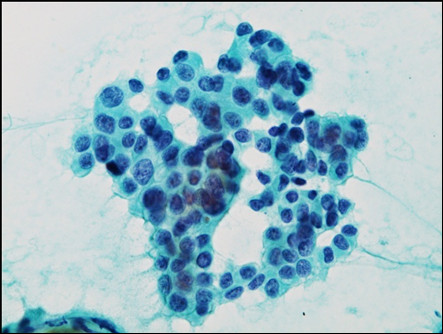

<caption><center> 細針穿刺抽吸細胞學影像 (<a href="https://www.researchgate.net/figure/Fine-needle-aspiration-cytology-demonstrated-sheet-clusters-of-atypical-epithelial-cells_fig4_51780466">影像來源</a>) </center></caption><br>


十個實數值的細胞核特徵由細針抽吸（fine needle aspiration cytology）的細胞病理影像樣本計算而來：
+ 半徑 **radius** (mean of distances from center to points on the perimeter)
+ 紋理 **texture** (standard deviation of gray-scale values)
+ 周長 **perimeter**
+ 面積 **area**
+ 形狀平滑度 **smoothness** (local variation in radius lengths)
+ 緊密度 **compactness** (perimeter^2 / area - 1.0)
+ 輪廓凹陷度 **concavity** (severity of concave portions of the contour)
+ 輪廓凹陷點 **concave points** (number of concave portions of the contour)
+ 對稱性 **symmetry**
+ 碎形維度 **fractal dimension** ("coastline approximation" - 1)

每個影像的這十個特徵都分別計算 mean，standard error，以及 worst（三個最大值的平均），共 30 個特徵欄位。


In [5]:
# 載入案例資料
dfbcw = pd.read_csv('./dataset/BreastCancerWisconsin/data.csv')

# TODO: 改成使用 scikit-learn 內建的
# sklearn.datasets.load_breast_cancer()

按照機器學習標準程序，載入資料後先觀察資料特性，做必要的前處理：

+ 哪些是特徵欄位 X？ 哪些是目標欄位 Y？ 有沒有多餘的不要進入模型訓練的欄位？
+ 都是連續數值欄位嗎？ 有沒有類別欄位？
+ 有沒有漏失數據？ 有沒有空值要填補或插補？
+ 數值欄位的數值分布狀況？ 要怎麼正規化？
+ 目標類別分布狀況如何？ 數量是否平均？
+ 特徵與目標之間是否有線性相關？ 各特徵之間是否有線性相關？

In [6]:
# 資料欄位基本檢視
dfbcw.info()

# 觀察： 已知 "id" 對預測模型沒有意義
# 觀察： "Unnamed: 32" 全部是空值，是多餘的沒用欄位
# 觀察： 診斷結果是類別型態的資料
# 觀察： 特徵欄位都是數值型態的資料，都沒有空值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [7]:
# 丟掉 "id" 與 "Unnamed: 32" 欄位
dfbcw.drop(columns=['id', 'Unnamed: 32'], inplace=True)

In [8]:
# 目標類別數量分布狀況
dfbcw['diagnosis'].value_counts() / dfbcw['diagnosis'].count()

# 觀察： 惡性的類別比較少，稍微不平衡

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [9]:
# 只有 diagnosis 欄位是類別資料，將良性與惡性的類別分別轉為 0 與 1
dfbcw['diagnosis'] = dfbcw['diagnosis'].map({'B':0, 'M':1})

In [10]:
# 數值欄位的數值分布狀況
display(dfbcw.iloc[:,1:11].describe())
display(dfbcw.iloc[:,11:21].describe())
display(dfbcw.iloc[:,21:].describe())

# 觀察： 尺度差異大，針對類神經網路模型的演算法，正規化是必要的

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795
std,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646
min,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895
25%,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248
50%,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187
75%,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558
max,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840


,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


沒有一個事先定義的值域範圍，正規化的處理只能由現有數據中的數值分布狀況決定。 實際案例應該要使用 k-fold 交叉驗證，因此正規化比較適合在分割 train/test 資料集之後分別處理，以避免可能的數據洩漏陷阱。

### § 相關係數

統計上有幾種常用的[相關係數](https://en.wikipedia.org/wiki/Correlation_coefficient)，一般提到相關係數指的都是 [Pearson相關係數](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) $r$。
+ Pearson相關係數度量兩個數列 x 和 y 之間的**線性相關**程度。
+ 相關係數 $r$ 的值介於 [-1, 1] 之間。
+ $r=1$ 表示完全線性匹配的正相關，y 在一條直線上隨著 x 增加而增加。
+ $r=0$ 表示x 和 y 之間沒有線性相關性。
+ $r=-1$ 表示完全線性匹配的負相關，y 在一條直線上隨著 x 增加而減少。
+ $r$ 值大小與關係強弱的對應解釋方式沒有標準，需考慮變數實際意義上的度量精度。
+ 除了觀察 $r$ 值大小，同時也應該要檢驗 "假設沒有關係" 的推論的 $p$-value 顯著性。
+ 相關係數不受變數的尺度差異影響，正規化與否相關性不改變。

Pandas 的 DataFrame 有提供 `corr()` 的方法，預設就是 Pearson 的相關係數，但是沒有返回 $p$-value，通常用來在 `seaborn.heatmap`上視覺化顯示。 要觀察有 $p$-value 的計算結果，可以使用 `scypy.stats` 模組的 `pearsonr()` 函數。

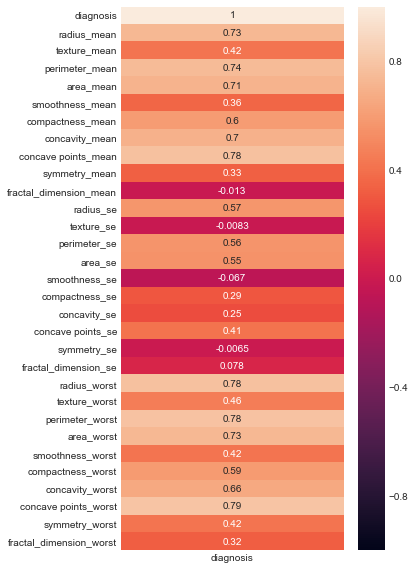

In [11]:
# 各特徵值與診斷結果相關性（corr 預設是 Pearson 的相關係數）
plt.figure(figsize=(5, 10))
sns.heatmap(dfbcw.corr()[['diagnosis']], annot=True, vmin=-1, vmax=1)

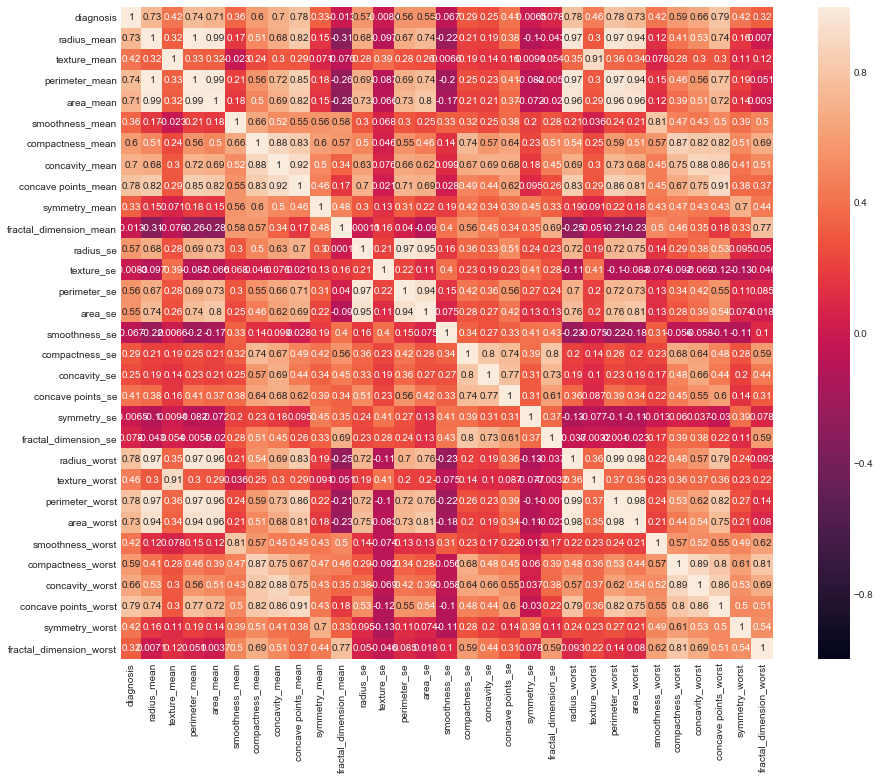

In [12]:
# 各特徵值之間的相關性（corr 預設是 Pearson 的相關係數）
plt.figure(figsize=(16, 12))
sns.heatmap(dfbcw.corr(), annot=True, square=True, vmin=-1, vmax=1)

很多資料集的數據不是常態分佈，欄位之間也很難有線性關係。 在 Breast Cancer Wisconsin 資料集中，我們很幸運地可以觀察到有些特徵值與診斷結果有線性相關，特徵與特徵兩兩之間也出現一些高度相關的。 根據相關係數觀察到的現象，可以用來篩選特徵（feature selection），以降低特徵的維度：

+ 首先丟掉與目標欄位相關性非常低的特徵（如： $-0.2 \le r \le 0.2$），保留相關性高的特徵。
+ 保留下來相關性高的特徵中，有出現兩兩高度相關的（如： $r> 0.9$），通常去掉其中一個對模型的預測能力影響不大。

有效的特徵篩選通常可以讓模型更容易訓練，泛化能力更好。 以下 DNN 模型先使用所有特徵，測試特徵篩選的效果就當作課後作業練習。

In [13]:
# 分離特徵 X 與目標 Y
bcw_y = dfbcw['diagnosis']
bcw_X = dfbcw.drop(columns=['diagnosis'])

In [14]:
from scipy import stats
# 特徵 X 與 y 兩兩計算相關係數，將 r 值與 p-value 記錄成一個表格
R = pd.DataFrame(np.zeros((2,bcw_X.shape[1])), columns=bcw_X.columns, index=['r', 'p-value'])
for col in bcw_X.columns:
    R[col]['r'], R[col]['p-value'] = stats.pearsonr(bcw_X[col], bcw_y)

# 顯示計算結果
display(R.iloc[:,:10])
display(R.iloc[:,10:20])
display(R.iloc[:,20:])

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
r,7.300285e-01,4.151853e-01,7.426355e-01,7.089838e-01,3.585600e-01,5.965337e-01,6.963597e-01,7.766138e-01,3.304986e-01,-0.012838
p-value,8.465941e-96,4.058636e-25,8.436251e-101,4.734564e-88,1.051850e-18,3.938263e-56,9.966556e-84,7.101150e-116,5.733384e-16,0.759937


,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se
r,5.671338e-01,-0.008303,5.561407e-01,5.482359e-01,-0.067016,2.929992e-01,2.537298e-01,4.080423e-01,-0.006522,0.077972
p-value,9.738949e-50,0.843332,1.651905e-47,5.895521e-46,0.110297,9.975995e-13,8.260176e-10,3.072309e-24,0.876642,0.063074


,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
r,7.764538e-01,4.569028e-01,7.829141e-01,7.338250e-01,4.214649e-01,5.909982e-01,6.596102e-01,7.935660e-01,4.162943e-01,3.238722e-01
p-value,8.482292e-116,1.078057e-30,5.771397e-119,2.828848e-97,6.575144e-26,7.069816e-55,2.464664e-72,1.969100e-124,2.951121e-25,2.316432e-15


### § 建構二元分類 DNN 模型

#### § Weight Initializer and Activation
開始訓練類神經網路的第一件事就是先把權重參數初始化，初始化的值對訓練結果影響很大，當網路結構越加越深，已知常會面臨兩個問題：
+ 初始化權重 $w > 1 \dots$ 往深層傳播 $\rightarrow$ **梯度爆炸 (exploding gradients)**
+ 初始化權重 $w = 0 \dots$ $\implies$ **線性模型**
+ 初始化權重 $w < 1 \dots$ 往深層傳播 $\rightarrow$ **梯度消失 (vanishing gradients)**

為了讓類神經網路可以建得更深來學習更複雜的函數，有不少的研究提出了有效的權重初始化方案來避免梯度爆炸及加快收斂速度，重點整理如下：
+ 針對深層 DNN 的隱藏層，activation 使用 **`relu`** 是首選，適合搭 **`he_normal`** 初始化。
+ 使用 **`sigmoid`** 或 **`tanh`** 的 activation，適合搭配 **`glorot_normal`**（又稱 Xavier）初始化。

相關 API 文件說明連結：
+ [`activations`](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
+ [`initializers`](https://www.tensorflow.org/api_docs/python/tf/keras/initializers)

#### § Batch Normalization
首先，正規化對大多數的機器學習演算法都有正面的助益。 開始訓練 DNN 網路之前，先對特徵欄位的正規化調整尺度是必要的，這對梯度下降演算法的收斂性有幫助。 那訓練過程中 DNN 網路的神經元呢？ 怎麼正規化？ DNN 可以看成是許多函數（隱藏層）合成的數學模型，梯度提供了如何更新每個參數的資訊，前提是其他層保持不變，但事實上反向傳播的演算法會同時更新每一層，這增加了使用梯度最佳化的問題複雜度。 若能至少每一層持續維持某種程度的正規化，可以降低梯度學習的複雜度。

*Batch Normalization* 是在 2015 年提出的一個有效的方法，現在被廣泛使用在許多 DNN 結構設計中。 基本的概念是，在學習過程對每一層的小批量（mini-batch）做正規化；但由於每一層就當成是解析複雜模型的其中一個基底函數，如果每一層都是平均 0 變異數 1 分佈的化，對複雜模型的解釋能力肯定不好，所以會希望每一層都能自適應性學習適合的分佈偏移。 若任一層的輸入與權重計算結果為 $Z = WX + b$，對該層正規化可表示為：

\begin{equation}
    Z_n = \frac{Z - \mu^2}{\sqrt{\sigma^2 + \epsilon}}
\end{equation}

然後新增參數讓分佈是平均 0 變異數 1 的 $Z$ 可以偏移，

\begin{equation}
    \tilde{Z} = \gamma\,Z_n + \beta
\end{equation}

每一層的中心及變異的偏移量 $\gamma\, \beta$ 由 DNN 網路學習，於是 $\gamma$ 及 $\beta$ 變成權重 $w$ 之外新的可調可學習參數。 加入 *Batch Normalization* 可以加速學習、避免梯度消失問題、降低權重參數初始化的影響，據說也有一些對抗 Overfitting 的效果。
+ 若激活函數使用 `relu`，`BatchNormalization` 可以加在激活之前或之後。
+ 若激活函數使用 `sigmoid` 或 `tanh`，`BatchNormalization` 加在激活之前。
+ 使用 `BatchNormalization` 時，`batch_size` 不宜設得太小。

相關 API 文件說明連結：
+ [`BatchNormalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

#### § Regularizers
Regularization 是用來解決 Overfitting 的問題，概念是在 loss/cost function 加上懲罰項（penalty term），使得發生過度學習時的損失變大。 對於有 $m$ 筆樣本數據的 cost function $J(w, b)$，常用的 regularization 有 $L1$ 及 $L2$ 兩種。

\begin{equation}
    \textbf{L1 Regularization: }\;\; J(w, b) = \frac{1}{m} \sum_{i=1}^{m} \mathcal{L}(\hat{y_{i}}, y_{i}) + \frac{\lambda}{2m} |w|
\end{equation}

\begin{equation}
    \textbf{L2 Regularization: }\;\; J(w, b) = \frac{1}{m} \sum_{i=1}^{m} \mathcal{L}(\hat{y_{i}}, y_{i}) + \frac{\lambda}{2m} \|w\|^{2}
\end{equation}

經過 **L1** regularizer 後的結果，有讓權重稀疏化（sparse）的效果，常用來降低參數的維度。 **L2** regularizer 又稱為 weight decay，加上 **L2** regularizer 後的成本函數，$J(w, b)$ 會強迫權重 $w$ 在擬合 $y$ 與盡量小之間做取捨。

相關 API 文件說明連結：
+ [`regularizers`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
+ [`Usage of regularizers`](https://keras.io/regularizers/)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam

def create_dnnlr_model():
    # 建立 Sequential 物件，指定網路結構配置
    model = Sequential([
        # 第一層隱藏層
        Dense(units=48, input_shape=(30,), kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        # 第二層隱藏層
        Dense(units=32, kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('relu'),
        # 第三層隱藏層
        Dense(units=24, kernel_initializer='he_normal', activation='relu', activity_regularizer=l1(0.01)),
        BatchNormalization(),
        # 輸出層
        Dense(units=1),
        Activation('sigmoid'),
    ])
    # 指定套用學習/訓練的方法
    model.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# 使用 3-fold 交叉驗證
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
histories = []
scores = []
for k, (train, test) in enumerate(skfold.split(bcw_X, bcw_y)):
    # 標準化
    stdscaler = StandardScaler()
    train_X = stdscaler.fit_transform(bcw_X.iloc[train,:])
    test_X = stdscaler.transform(bcw_X.iloc[test,:])
    train_y = bcw_y.iloc[train]
    test_y = bcw_y.iloc[test]
    # 建立 dnnlr 模型
    dnnlr = create_dnnlr_model()    
    # 指定訓練資料的配置，開始訓練
    history = dnnlr.fit(x=train_X, y=train_y, batch_size=None, epochs=200, verbose=1)
    histories.append(history)
    # 評估驗證集
    score = dnnlr.evaluate(x=test_X, y=test_y, batch_size=None, verbose=1)
    scores.append(score)

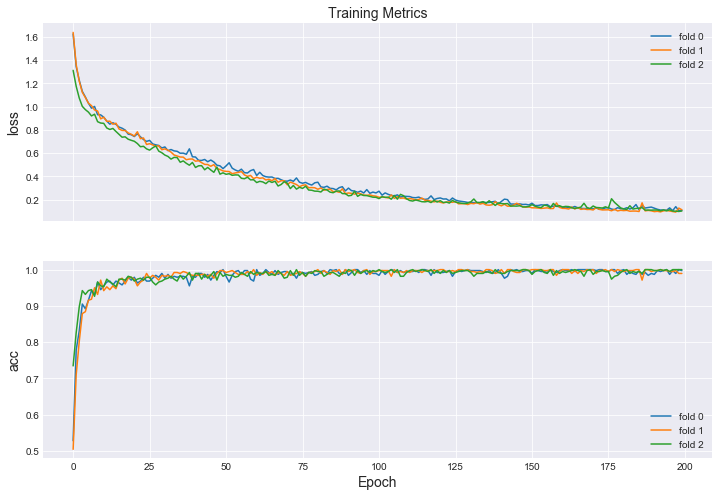

In [17]:
# 觀察訓練過程的 loss 與 accuracy 值
plot_kfold_metrics(histories)

In [18]:
# 觀察驗證結果的 loss 與 accuracy 值
dfscore = pd.DataFrame(scores, index=['validation 1', 'validation 2', 'validation 3'], columns=dnnlr.metrics_names)
dfscore.loc['Average',:] = np.mean(scores, axis=0)
display(dfscore)

,loss,acc
validation 1,0.228497,0.957895
validation 2,0.238533,0.947368
validation 3,0.153132,0.978836
Average,0.206720,0.961366


### § 準備佈署模型

+ 使用挑選出來最好的超參數設定。
+ 佈署的模型使用全部資料來訓練。
+ 將訓練好的模型儲存成檔案。

In [ ]:
from sklearn.preprocessing import StandardScaler
# 標準化
stdscaler = StandardScaler()
X_train = stdscaler.fit_transform(bcw_X)
y_train = bcw_y
# 建立 annlr 模型
dnnlr = create_dnnlr_model()
# 指定套用學習/訓練的方法
dnnlr.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
# 指定訓練資料的配置，開始訓練
history = dnnlr.fit(x=X_train, y=y_train, batch_size=None, epochs=200, verbose=1)

Class0: 良性(B)
Class1: 惡性(M)
真實 Y： Class0 357 筆 + Class1 212 筆
預測 Y： Class0 357 筆 + Class1 212 筆


Recall       1.0
Precision    1.0
Accuracy     1.0
dtype: float64

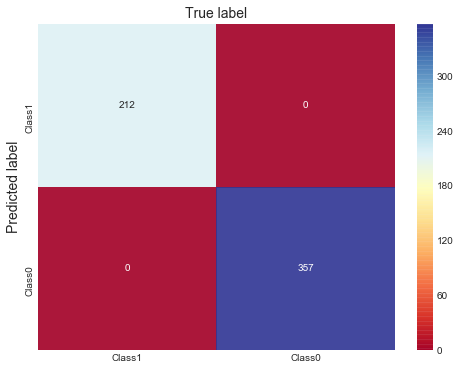

In [20]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

y_pred = dnnlr.predict_classes(X_train, verbose=0)

# 顯示分類結果報告
print('Class0: 良性(B)\nClass1: 惡性(M)')
tclass, tcount = np.unique(y_train, return_counts=True)
pclass, pcount = np.unique(y_pred, return_counts=True)
print('真實 Y： Class{} {} 筆 + Class{} {} 筆'.format(tclass[0], tcount[0], tclass[1], tcount[1]))
print('預測 Y： Class{} {} 筆 + Class{} {} 筆'.format(pclass[0], pcount[0], pclass[1], pcount[1]))
# 分類效能指標
display(pd.Series({'Recall': recall_score(y_train, y_pred),
                   'Precision': precision_score(y_train, y_pred),
                   'Accuracy': accuracy_score(y_train, y_pred)}))

# 劃出 confusion 矩陣
plot_confusion_matrix(y_train, y_pred)

In [21]:
from tensorflow.keras.models import save_model, load_model

# 輸出成檔案
save_model(dnnlr, 'breast_cancer_wisconsin_dnnlr.h5')

# 載入檔案
#bcw_dnnmodel = load_model('./breast_cancer_wisconsin_dnnlr.h5')

<a id="case-multilabel-classification"></a>

## 18.2 多類別分類案例 – Iris 資料集

這個著名的資料集包含了三種鳶尾花類別： Setosa、Virginica、Versicolor，每一種類別 50 筆，共有 150 筆。 四個特徵欄位分別記錄花萼（Sepal）及花瓣（Petal）的長度和寬度的量測值（cm）。

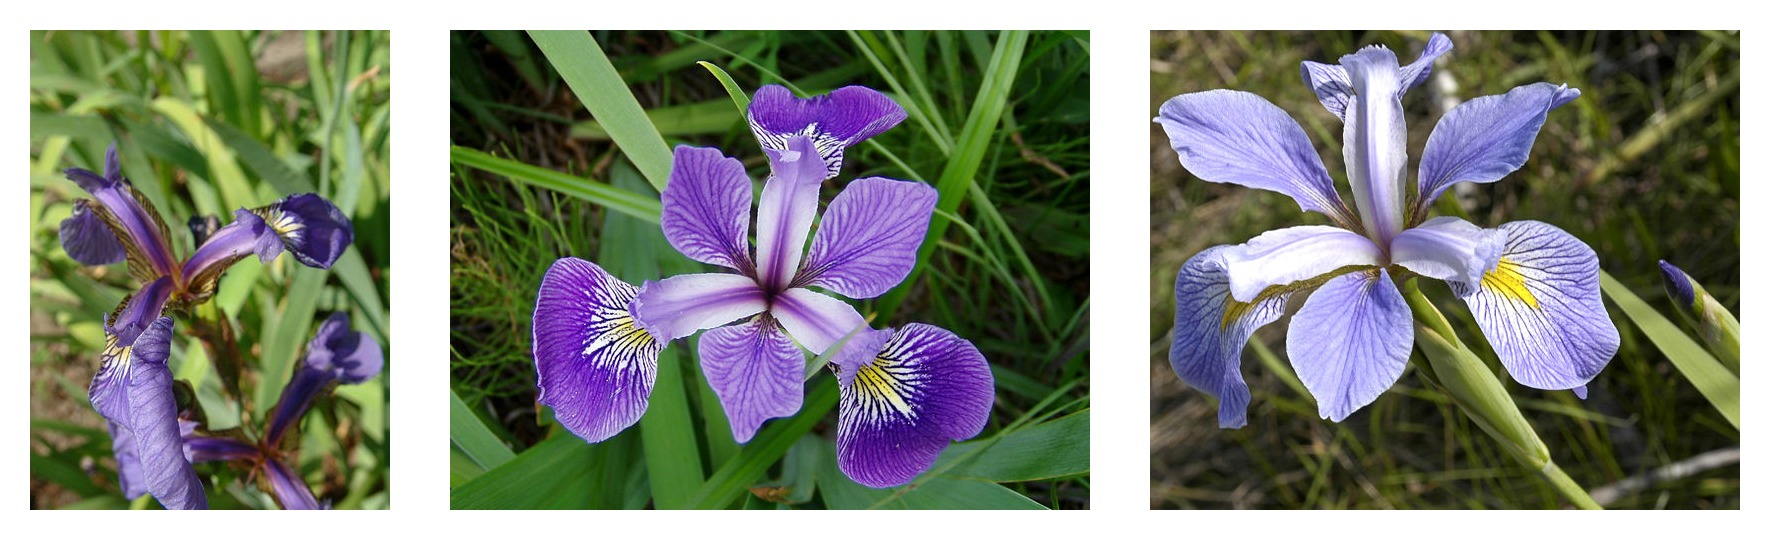
<caption><center> 三種鳶尾花類別影像：
    <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a>、
    <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>、
    <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a>
</center></caption><br>


In [22]:
# 載入案例資料
dfiris = pd.read_csv('./dataset/Iris/data.csv')

# TODO: 改成使用 scikit-learn 內建的
# sklearn.datasets.load_iris()

In [23]:
dfiris.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,label
139,6.9,3.1,5.4,2.1,virginica
121,5.6,2.8,4.9,2.0,virginica
146,6.3,2.5,5.0,1.9,virginica
106,4.9,2.5,4.5,1.7,virginica
35,5.0,3.2,1.2,0.2,setosa


### § 配對散佈圖

這個小型資料集只有四個特徵欄位，非常適合用兩兩配對散佈圖的 pairplot 來觀察，雖然一次只看兩個維度的特徵，但這與 [特徵降維（dimensionality reduction）](https://en.wikipedia.org/wiki/Dimensionality_reduction) 的基本概念一致。 高維度的資料不好觀察特徵與分類目標的關係，而且肯定不能簡單線性分割，但若是投影到某個超平面，有機會可以找到線性就可以分離目標類別的決策模型，至於要如何找到這個超平面？ 從這個想法就衍生了一些著名的特徵降維的分類方法。

從 Iris 資料集的 piarplot 可以觀察到：
+ **setosa** 類別在任意一對特徵平面中都非常容易線性分割，尤其在 petal_length 和 petal_width 很明顯可以區分。
+ **versicolr** 和 **virginica** 兩種類別不容易線性分割，但也是 petal_length 和 petal_width 有比較明顯可以有決策邊界。

由以上觀察的發現，對學習模型的建立有甚麼想法？

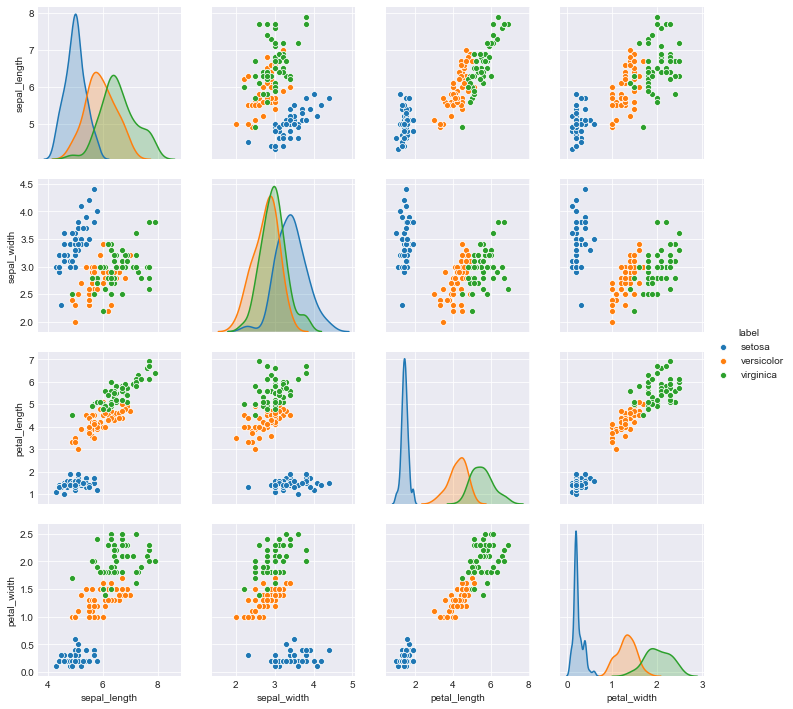

In [24]:
sns.pairplot(dfiris, hue='label')

### § 建構多類別 DNN 分類模型

按照常用的多類別 DNN 模型，網路在輸出層使用 softmax 激活，目標函數使用 cross entropy。

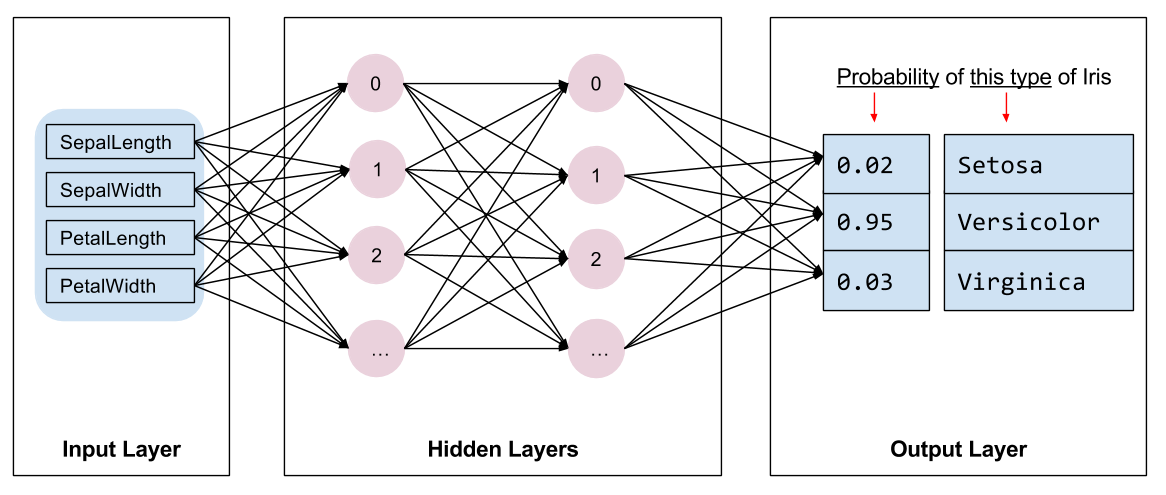


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam

def create_dnnsc_model():
    # 建立 Sequential 物件，指定網路結構配置
    model = Sequential([
        # 第一層隱藏層
        Dense(units=32, activation='relu',input_shape=(4,)),
        # 第二層隱藏層
        Dense(units=16, activation='relu'),
        # 輸出層
        Dense(units=3, activation='softmax')
    ])
    # 指定套用學習/訓練的方法
    model.compile(optimizer=Adam(lr=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

這次的交叉驗證範例採用 [Keras Scikit-Learn API](https://keras.io/scikit-learn-api/)，建構網路的方式不變，只是透過這個介面把 Keras 的網路模型封裝成 Scikit-Learn 相容的 Estimator，包含了 [`KerasClassifier`](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier) 及 [`KerasRegressor`](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor) 類別，以方便使用 Scikit-Learn 提供的各種方便機器學習流程的函式，如以下範例中的 `Pipeline`、`cross_val_score`。 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

iris_y = dfiris['label'].map({'setosa':0, 'versicolor':1, 'virginica':2})
iris_Y_cat = pd.get_dummies(iris_y)
iris_X = dfiris.drop(columns=['label'])

# 使用 Scikit-Learn estimator 相容的 Keras API
estimator = KerasClassifier(build_fn=create_dnnsc_model,
                            epochs=100,
                            batch_size=None,
                            verbose=1)
# 使用 Scikit-Learn pipeline
dnnsc_pipe = Pipeline(steps=[
    ('normalize', StandardScaler()),
    ('dnnmodel', estimator)
])

scores = cross_val_score(dnnsc_pipe,
                         iris_X,
                         iris_Y_cat,
                         cv=5,
                         n_jobs=1,
                         verbose=3)

In [27]:
# 顯示交叉驗證的 accuracy 
print('5-fold 交叉驗證正確率：', scores)
print('平均正確率： {:.3f} ± {:.5f}'.format(scores.mean(), scores.std()))

5-fold 交叉驗證正確率： [1.         0.96666664 0.83333331 0.93333334 0.83333331]
平均正確率： 0.913 ± 0.06864


採用 Scikit-Learn API 的缺點是 Keras 模型 `fit()` 所返回的訓練過程 `History` 沒有機制可以儲存下來供事後檢視，所以這個 Scikit-Learn API 的使用時機比較適合用在不關心過程、只關心結果的超參數搜尋，如 `RandomizedSearchCV`、或 `GridSearchCV`。

In [ ]:
from sklearn.preprocessing import StandardScaler

# 建立 DNN 模型
dnnsc = create_dnnsc_model()
dnnsc.summary()

stdscaler = StandardScaler()
history = dnnsc.fit(x=stdscaler.fit_transform(iris_X), y=iris_Y_cat, batch_size=None, epochs=100, verbose=1)

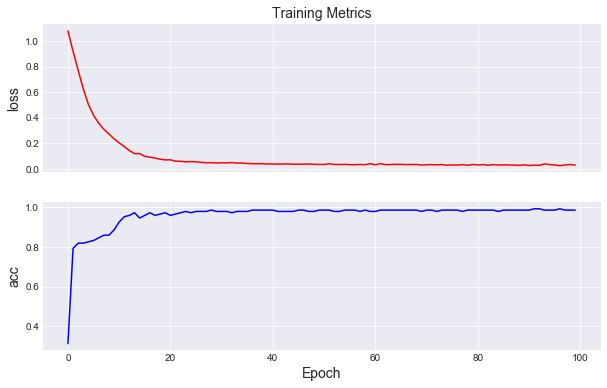

In [32]:
# 觀察訓練過程的 loss 與 accuracy 值
plot_metrics(history)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



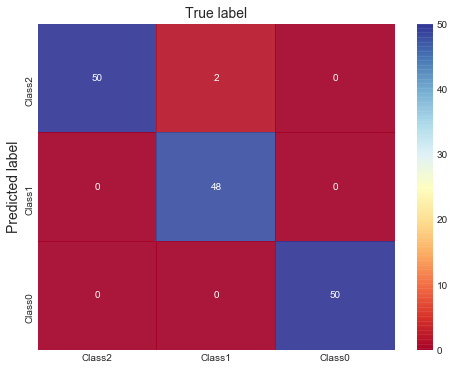

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

stdscaler = StandardScaler()
iris_y_pred = dnnsc.predict_classes(stdscaler.fit_transform(iris_X), verbose=0)

# 顯示分類結果報告
print(classification_report(iris_y, iris_y_pred))

# 劃出 confusion 矩陣
plot_confusion_matrix(iris_y, iris_y_pred)

<a id="case-regression"></a>

## 18.3 回歸案例

TODO

<a id="references"></a>

## References:

+ UCI ML Breast Cancer Wisconsin (Diagnostic) dataset [[link]](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))
+ Iris dataset [[link]](https://archive.ics.uci.edu/ml/datasets/iris)
+ Ian Goodfellow and Yoshua Bengio and Aaron Courville, *"Deep Learning"*, MIT Press, 2016. [[link]](http://www.deeplearningbook.org)
+ A. Dertat, *"Applied Deep Learning - Part 2: Real World Case Studies"*, Towards Data Science, 2017. [[link]](https://towardsdatascience.com/applied-deep-learning-part-2-real-world-case-studies-1bb4b142a585)
+ N. Dorshi, *"Deep Learning Best Practices (1) — Weight Initialization"*, Medium, 2018. [[link]](https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94)
+ 李宏毅, *"Batch Normalization"*, Machine Learning and having it Deep and Structured, 2017. [[youtube]](https://www.youtube.com/watch?v=BZh1ltr5Rkg)